# Notebook analyse CAREI des Seniors
Par Simon OUELLET oct 2022

## Importation des librairies Python utiles et nécessaires à l'exécution de ce notebook

In [13]:
import numpy as np
import pandas as pd
#import modin.pandas as pd
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer

from bokeh.plotting import figure, ColumnDataSource, show, output_notebook, output_file
from bokeh.models import HoverTool

## Fonctions spécifiques utile à l'analyse ACP/PCA

In [14]:
font_size = 3
def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]


def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))


def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)


def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=False):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X)
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)
    
    plt.rcParams.update({'font.size': font_size})
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

    # save and show p
    if save_plot:
        output_file('PCA_analysis.html')
    show(p)
        
    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        plt.rcParams.update({'font.size': font_size})
        plt.rc('font', size=font_size)          # controls default text sizes
        plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
        plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
        plt.rc('legend', fontsize=font_size)    # legend fontsize
        plt.rc('figure', titlesize=font_size)  # fontsize of the figure title
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        plt.rcParams.update({'font.size': font_size})
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            plt.rcParams.update({'font.size': font_size})
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)

## Chargement des données depuis les fichiers .csv
Les données sont chargées dans un DataFrame Pandas.  
Le séparateur de champs est spécifié car par défaut c'est la virgule qui est utilisée et dans le cas de ces fichiers CSV, c'est le point-virgule qui est utilisé.  
Il est également nécessaire de spécifier le characterset iso-8859-1.

In [15]:
seniors_df = pd.read_csv('carei_sen_seniors_v3_211203.csv', sep=";", encoding='iso-8859-1')
revenus_df = pd.read_csv('care_i_revenus_quetelet.csv', sep=";", encoding='iso-8859-1')
mortalite_df = pd.read_csv('suivimortalite2021_carei.csv', sep=";", encoding='iso-8859-1')

In [16]:
seniors_df

,groupelarge,grouperestreint,idsenior,axelarge1,axelarge2,axelarge3,axelarge4,axelarge5,axelarge6,axelarge7,...,FIHANDET3,FIHANDET4,FIHANDET5,FIHANDET6,FIAIDND,FIENQSEX,FIENQAGE,NBPROXYPRO,NBPROXYENT,NBPROXTOT
0,5,6,1000_01,B,C,B,A,A,A,A,...,NaN,NaN,NaN,NaN,0,1,67,0,1,1
1,3,3,1000_02,B,C,B,A,B,C,A,...,NaN,NaN,NaN,NaN,0,1,67,0,2,2
2,2,3,1000_03,B,C,C,C,B,C,C,...,NaN,NaN,NaN,NaN,0,1,67,0,1,1
3,3,5,1000_04,A,C,B,B,A,B,B,...,NaN,NaN,NaN,NaN,0,1,67,0,1,1
4,1,2,1000_05,C,C,C,C,C,C,C,...,NaN,NaN,NaN,NaN,0,1,67,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,2,2,1699_02,B,B,C,C,B,C,C,...,NaN,NaN,NaN,NaN,0,1,50,2,0,2
3258,1,2,1699_03,C,C,C,C,C,C,C,...,NaN,NaN,NaN,NaN,0,1,50,1,0,1
3259,2,2,1699_04,B,C,C,C,C,C,C,...,NaN,NaN,NaN,NaN,0,1,50,1,0,1
3260,4,6,1699_05,B,C,B,A,B,A,A,...,NaN,NaN,NaN,NaN,0,1,50,2,0,2


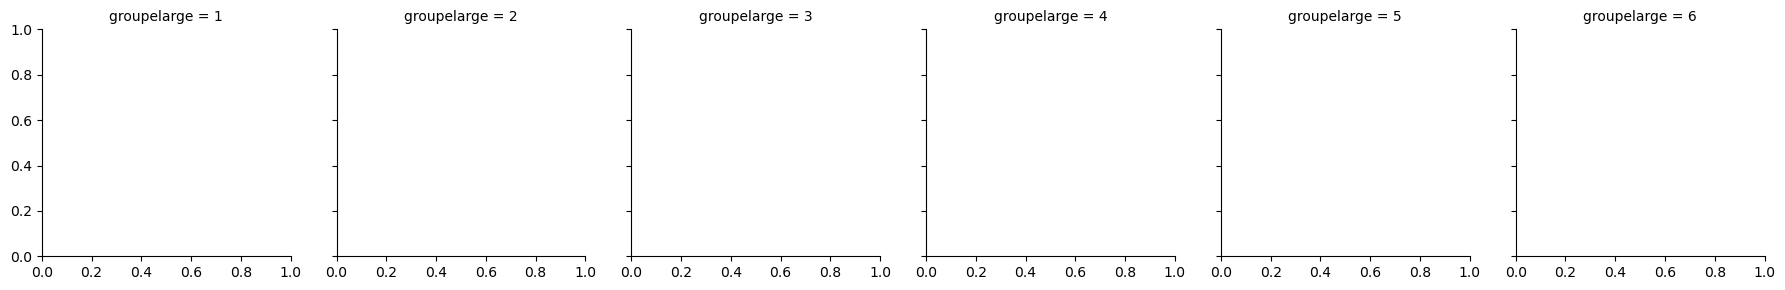

In [29]:
g = sns.FacetGrid(seniors_df, col='groupelarge', hue="FIENQAGE")

## Unification des différentes sources de données en un seul dataframe pandas
La fonction merge permet de joindre deux dataframe.  
Dans le cas présent, c'est la variable idsenior qui servira d'information pour la jointure.  
La jointure est de type "left join".

### Version avec la methode "merge"

In [31]:
%time
big_seniors_df = seniors_df.merge(revenus_df, how='left', left_on='idsenior', right_on='IDSENIOR').merge(mortalite_df, how='left', on='idsenior')

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 15.7 µs


### Version avec la méthode "join"

In [32]:
%time
big_seniors_df = seniors_df.set_index('idsenior').join(revenus_df.set_index('IDSENIOR')).join(mortalite_df.set_index('idsenior'))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.9 µs


## Dataprep

### Suppression de colonnes à forte co-linearitées ou inutiles

In [33]:
seniors_selections01_df = big_seniors_df.drop(columns=['IDETAB',
                                                                'EJ_STATUT', 
                                                                'POIDS_ETAB', 
                                                                'POIDS_SENIOR', 
                                                                'TCENTAUT_C', 
                                                                'ACCOMWA',
                                                                'TUJURD1',
                                                                'TUJURD2',
                                                                'TUJURDUT1',
                                                                'TUJURDUT2',
                                                                
                                                               ])

### Remplacement des valeurs nulles par 0

In [34]:
seniors_selections01_df.fillna(0, inplace=True)

### Changement des variables de valeurs continues en classes
Directives statistiques pour créer des classes :  
1. Utiliser des classes de même amplitude avec des centres aux valeurs arrondies appropriées.  
2. Pour un petit nombre de données, utiliser un petit nombre de classes.  
3. Pour un grand nombre de données, utiliser plus de classes.

Exemple d'analyses pour déterminer la façon appropriée de créer les classes

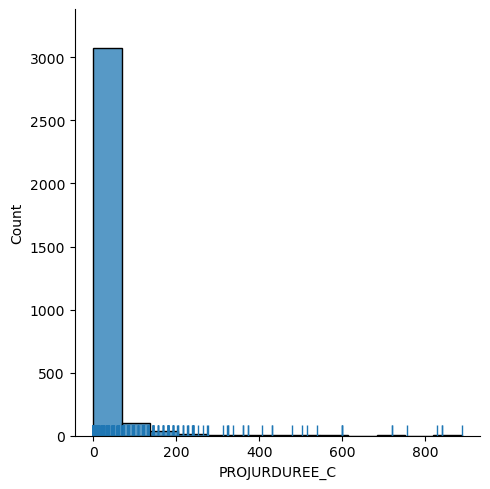

In [35]:
sns.displot(seniors_selections01_df['PROJURDUREE_C'], kind="hist", rug=True)

<AxesSubplot:xlabel='PROJURDUREE_C', ylabel='Count'>

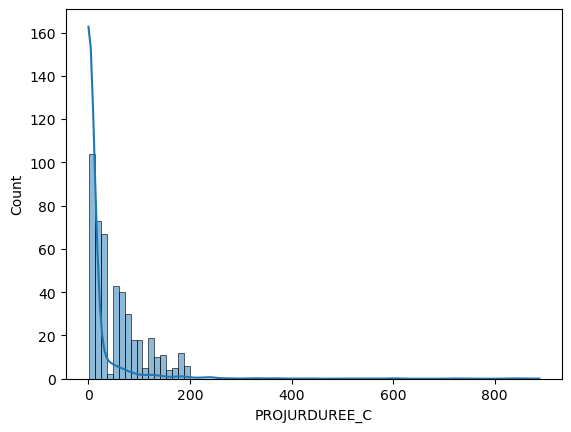

In [35]:
sns.histplot(seniors_selections01_df['PROJURDUREE_C'], binrange=[1,200], kde=True)

In [38]:
PROJURDUREE_C_class = pd.cut(seniors_selections01_df['PROJURDUREE_C'], bins=[1,30,90,180,365,999], labels=['1-30j','31-90j','91-180j','181-365j','+365j'])

In [37]:
PROJURDUREE_C_class = pd.qcut(seniors_selections01_df['PROJURDUREE_C'], q=100, precision=0, duplicates='drop')

In [39]:
seniors_selections01_df['PROJURDUREE_C']

idsenior
1000_01     0.0
1000_02     0.0
1000_03     0.0
1000_04     0.0
1000_05     0.0
           ... 
1699_02     0.0
1699_03     0.0
1699_04    36.0
1699_05     0.0
1699_06     0.0
Name: PROJURDUREE_C, Length: 3262, dtype: float64

TypeError: Invalid object type at position 0

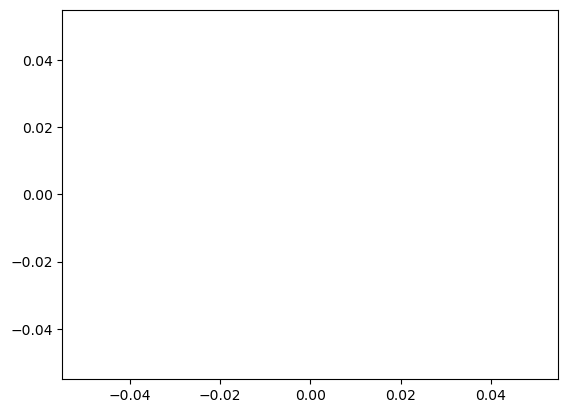

In [22]:
sns.histplot(PROJURDUREE_C_class, kde=True)

In [56]:
seniors_selections01_df['PROJURDUREE_C'] = pd.cut(seniors_selections01_df['PROJURDUREE_C'], bins=[0,30,90,180,365,999], labels=['0-30j','31-90j','91-180j','181-365j','+365j'])
seniors_selections01_df['SDTAIL'] = pd.cut(seniors_selections01_df['SDTAIL'], bins=[120,127,134,142,149,156,163,170,178,185,192])
seniors_selections01_df['RPAMCC'] = pd.cut(seniors_selections01_df['RPAMCC'], bins=[0,25,50,75,100,125,150,200,250,300,400,500,10000])
seniors_selections01_df['FIENQAGE'] = pd.cut(seniors_selections01_df['FIENQAGE'], bins=[0,24,35,55,65,100])

### Changement des variables en type "category"

In [57]:
seniors_selections01_columns = set(seniors_selections01_df.columns)
#seniors_selections01_columns.remove('idsenior')
for c in seniors_selections01_columns:
    seniors_selections01_df[c] = seniors_selections01_df[c].astype('category')

In [61]:
seniors_selections01_df

,groupelarge,grouperestreint,axelarge1,axelarge2,axelarge3,axelarge4,axelarge5,axelarge6,axelarge7,axelarge8,...,MTNT_PLACEMENTFIN_I,RPRICH_1,RPRICH_2,RPRICH_3,RPRICH_4,RPRICH_5,RPRICHTT,RPRICHTO,DECES,DATEDECES
idsenior,,,,,,,,,,,,,,,,,,,,,
1000_01,4,5,1,2,1,0,0,0,0,0,...,208,1,0,0,0,0,15,0,0,0
1000_02,2,2,1,2,1,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,386
1000_03,1,2,1,2,2,2,1,2,2,2,...,0,0,0,0,0,0,0,0,1,677
1000_04,2,4,0,2,1,1,0,1,1,2,...,0,0,0,0,0,0,0,0,1,994
1000_05,0,1,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,1,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699_02,1,1,1,1,2,2,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1699_03,0,1,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,1,604
1699_04,1,1,1,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,1,45


### Changement des valeurs non numériques en labels numériques

In [59]:
le = preprocessing.LabelEncoder()
numerical_columns_name = seniors_selections01_df._get_numeric_data().columns
non_numrical_columns_list = list(seniors_selections01_df.loc[:, ~seniors_selections01_df.columns.isin(numerical_columns_name)].columns)
for column in non_numrical_columns_list:
    seniors_selections01_df[column] = le.fit_transform(
        seniors_selections01_df[column].astype('str'))

In [72]:
seniors_selections01_df.dropindex()

AttributeError: 'DataFrame' object has no attribute 'dropindex'

In [68]:
seniors_selections01_df

,groupelarge,grouperestreint,axelarge1,axelarge2,axelarge3,axelarge4,axelarge5,axelarge6,axelarge7,axelarge8,...,MTNT_PLACEMENTFIN_I,RPRICH_1,RPRICH_2,RPRICH_3,RPRICH_4,RPRICH_5,RPRICHTT,RPRICHTO,DECES,DATEDECES
idsenior,,,,,,,,,,,,,,,,,,,,,
1000_01,4,5,1,2,1,0,0,0,0,0,...,208,1,0,0,0,0,15,0,0,0
1000_02,2,2,1,2,1,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,386
1000_03,1,2,1,2,2,2,1,2,2,2,...,0,0,0,0,0,0,0,0,1,677
1000_04,2,4,0,2,1,1,0,1,1,2,...,0,0,0,0,0,0,0,0,1,994
1000_05,0,1,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,1,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699_02,1,1,1,1,2,2,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1699_03,0,1,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,1,604
1699_04,1,1,1,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,1,45


## Création des DataFrames de X (variables) et de Y (classe décès) 

In [73]:
s_Y = seniors_selections01_df['DECES']
s_X = seniors_selections01_df[seniors_selections01_df.columns[~seniors_selections01_df.columns.isin(['DECES', 'idsenior'])]]

In [74]:
s_X

,groupelarge,grouperestreint,axelarge1,axelarge2,axelarge3,axelarge4,axelarge5,axelarge6,axelarge7,axelarge8,...,REV_INTERETS_I,MTNT_PLACEMENTFIN_I,RPRICH_1,RPRICH_2,RPRICH_3,RPRICH_4,RPRICH_5,RPRICHTT,RPRICHTO,DATEDECES
idsenior,,,,,,,,,,,,,,,,,,,,,
1000_01,4,5,1,2,1,0,0,0,0,0,...,235,208,1,0,0,0,0,15,0,0
1000_02,2,2,1,2,1,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,386
1000_03,1,2,1,2,2,2,1,2,2,2,...,0,0,0,0,0,0,0,0,0,677
1000_04,2,4,0,2,1,1,0,1,1,2,...,0,0,0,0,0,0,0,0,0,994
1000_05,0,1,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699_02,1,1,1,1,2,2,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1699_03,0,1,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,604
1699_04,1,1,1,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,45


### Découpage des jeux de données en jeu d'entrainement et jeu de test
Le jeu de test correspond à 1 tier des données.

In [75]:
s_X_train, s_X_test, s_Y_train, s_Y_test = train_test_split(s_X.to_numpy(), s_Y.to_numpy(), test_size=0.33, random_state=42) 

### Standardisation et normalisation des données 
Les jeux de données sont standardisés et normalisés séparéments pour éviter le phénomène de "data leakeage".

In [76]:
scaler = StandardScaler()
nrmlz = Normalizer(norm="max")


transformer = RobustScaler().fit(s_X_train)
nrmlz = Normalizer(norm="max").fit(s_X_train)
s_X_train = transformer.transform(s_X_train)
s_X_train = nrmlz.transform(s_X_train)

transformer = RobustScaler().fit(s_X_test)
nrmlz = Normalizer(norm="max").fit(s_X_test)
s_X_train = transformer.transform(s_X_test)
s_X_train = nrmlz.transform(s_X_test)

transformer = RobustScaler().fit(s_Y_train)
nrmlz = Normalizer(norm="max").fit(s_Y_train)
s_Y_train = transformer.transform(s_Y_train)
s_Y_train = nrmlz.transform(s_Y_train)

transformer = RobustScaler().fit(s_Y_test)
nrmlz = Normalizer(norm="max").fit(s_Y_test)
s_Y_train = transformer.transform(s_Y_test)
s_Y_train = nrmlz.transform(s_Y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. ... 1. 0. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


*--- PCA Report ---*

X mean:		13.174
X variance:	20159.984

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 728 to 400 dimensions while retaining 95% of variance.
2 principal components explain 13.10% of variance.
3 principal components explain 15.50% of variance.
X*X_pca: (728, 3262) * (3262, 728) = (728, 728)


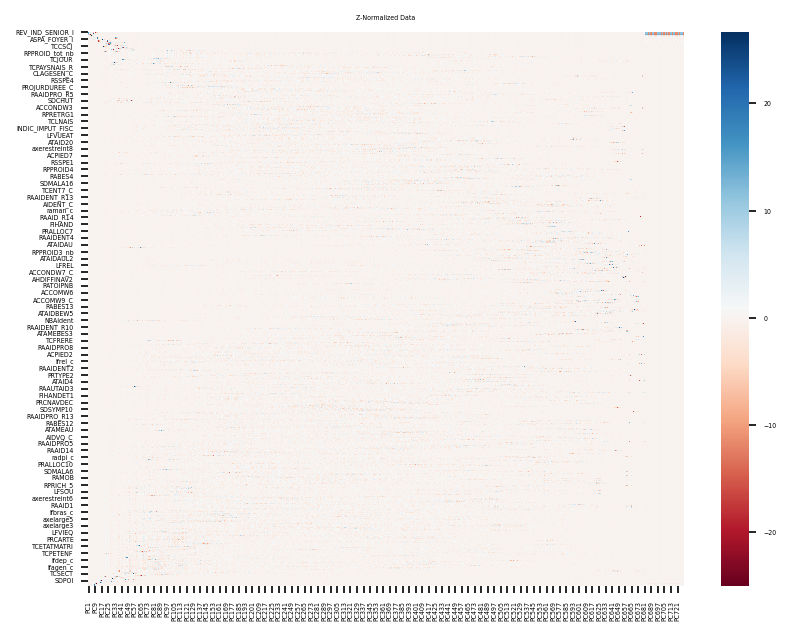

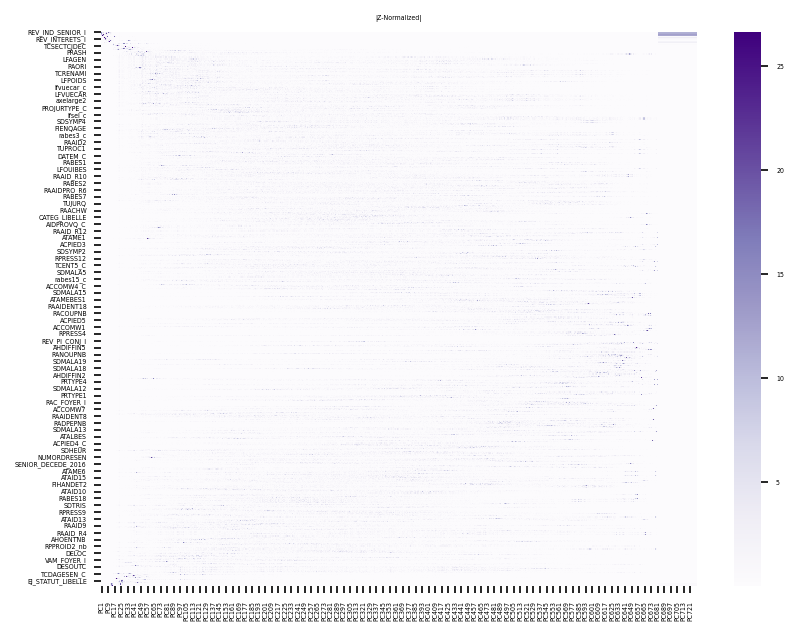

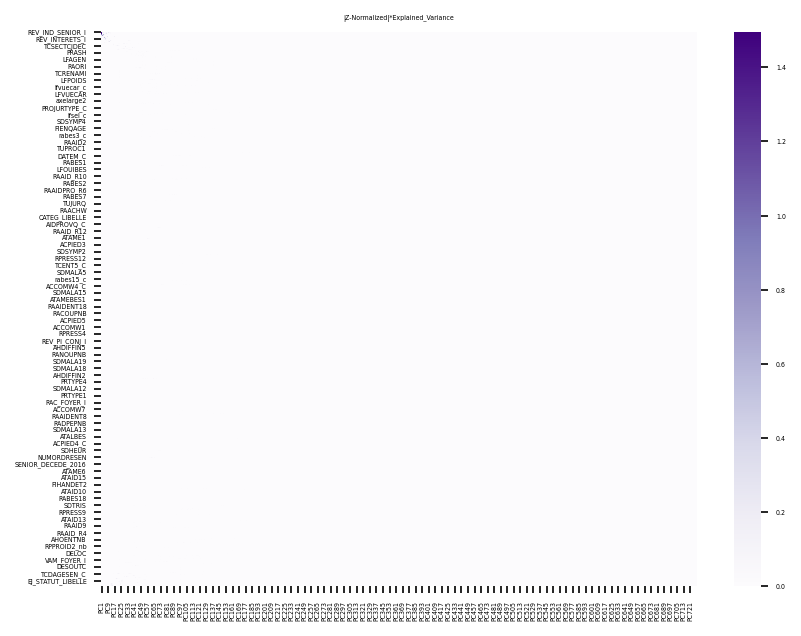

        score_           feature_
rank                             
1     2.249919  REV_RETR_SENIOR_I
2     2.224678   REV_IND_SENIOR_I
3     2.046778    REV_IND_FOYER_I
4     1.886765    REV_TOT_FOYER_I
5     1.216261           IMPOTS_I
...        ...                ...
724   0.041046           RATOIPNB
725   0.041046           RAORIPNB
726   0.041046           RATELPNB
727   0.041046            RPRESS5
728   0.041046      REV_PI_CONJ_I

[728 rows x 2 columns]


(           variance_cumulative      variance
 dimension                                   
 1                     0.102218  1.022181e-01
 2                     0.130775  2.855688e-02
 3                     0.154884  2.410927e-02
 4                     0.175403  2.051874e-02
 5                     0.193513  1.811015e-02
 ...                        ...           ...
 724                   1.000000  7.384690e-34
 725                   1.000000  7.384690e-34
 726                   1.000000  7.384690e-34
 727                   1.000000  7.384690e-34
 728                   1.000000  4.640890e-34
 
 [728 rows x 2 columns],
 array([[ 1.17411624e+03, -1.33076705e+03,  7.81683746e+01, ...,
         -9.16611587e-14,  5.16802191e-14,  2.16045318e-13],
        [-3.53498486e+01,  6.90165127e+02, -1.66458611e+02, ...,
          1.30375663e-13, -2.69300228e-13,  1.32571212e-13],
        [ 7.55746374e+02, -8.99355067e+02, -4.00137857e+02, ...,
         -4.94500313e-14,  8.16153315e-14,  9.07208146e-13

In [81]:
pca_full_report(X=seniors_selections01_df.to_numpy(), features_=seniors_selections01_df.columns)